In [28]:
#Imports the uproot module with the Events and View classes

from uproot_io import Events, View
import numpy as np
from tqdm import tqdm

In [29]:
import os
#A save function produced by Andy to enable us to save plots
def save_plot(fig, directory, filename):
    if not os.path.exists(directory):
        os.mkdir(directory)
    fig.savefig(f'{directory}/{filename}.png', bbox_inches='tight', dpi=200, facecolor='w')
    fig.savefig(f'{directory}/{filename}.jpg', bbox_inches='tight', dpi=200)
    fig.savefig(f'{directory}/{filename}.svg', bbox_inches='tight', dpi=200)

In [30]:
# Interaction type lookup - this is just a look up table that contains all of the possible interaction types as assigned
# to a number.

import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction

In [31]:
events = Events("CheatedRecoFile_1.root")
view_u = View(events, "u")
view_v = View(events, "v")
view_w = View(events, "w")

In [32]:
def scatter_points(plane, event_number):
    if plane=="u":
        view_u = View(events, "u")
        true_x = view_u.true_vtx_x[event_number]
        z_view = view_u.z[event_number]
        x_view = view_u.x[event_number]
        adc_view = view_u.adc[event_number]
        true_z = view_u.true_vtx_z[event_number]
    elif plane=="v":
        view_v = View(events, "v")
        true_x = view_v.true_vtx_x[event_number]
        z_view = view_v.z[event_number]
        x_view = view_v.x[event_number]
        adc_view = view_v.adc[event_number]
        true_z = view_v.true_vtx_z[event_number]
    elif plane=="w":
        view_w = View(events, "w")
        true_x = view_w.true_vtx_x[event_number]
        z_view = view_w.z[event_number]
        x_view = view_w.x[event_number]
        adc_view = view_w.adc[event_number]
        true_z = view_w.true_vtx_z[event_number]
    else:
        print("PLane not u,v,w")
    return x_view, z_view, adc_view, true_z, true_x

def threshold(plane, event_number, no_std):
    x_view, z_view, adc_view = scatter_points(plane, event_number)
    
    mean = np.average(adc_view)
    std = np.std(adc_view)

    x_view = x_view[(mean - no_std * std < adc_view)]
    z_view = z_view[(mean - no_std * std < adc_view)]
    adc_view = adc_view[(mean - no_std * std < adc_view)]
    
    return x_view, z_view, adc_view

def plotter(plane, event_number, thresholding=False, no_std=1):
    

    #threshold data to an input number of std
    if thresholding:
        x_view, z_view, adc_view = threshold(plane, event_number, no_std)
    else:
        x_view, z_view, adc_view = scatter_points(plane, event_number)


    
    plt.scatter(z_view, x_view, c=adc_view, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")
    return plt.show()
    

In [33]:
import matplotlib.pyplot as plt

def phi_hist(plane, event_number, thresholding=True, no_std=0.2, leastz=False, centre_coord=(0,0), no_sectors=20, centre=0, printhist=False):
    x_view, z_view, adc_view, true_z, true_x = scatter_points(plane, event_number)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    centred_x = x_view - centre_coord[1]
    centred_z = z_view - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score
        
def optimise_phi(plane, event_number, thresholding=True, no_std=0.2, no_sectors=20, centre=0, plot=True):
    x_view, z_view, adc_view, true_z, true_x = scatter_points(plane, event_number)
    no_points = len(x_view)
    score_arr = np.zeros(no_points)
    for i in tqdm(range(no_points)):
        centre_co = (z_view[i], x_view[i])
        score_arr[i] = phi_hist(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = z_view[ind], x_view[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]

optimise_phi("u", 10)

  4%|██▉                                                                            | 35/932 [08:13<3:30:54, 14.11s/it]


KeyboardInterrupt: 

Running...


100%|██████████████████████████████████████████████████████████████████████████████| 494/494 [00:00<00:00, 4507.37it/s]


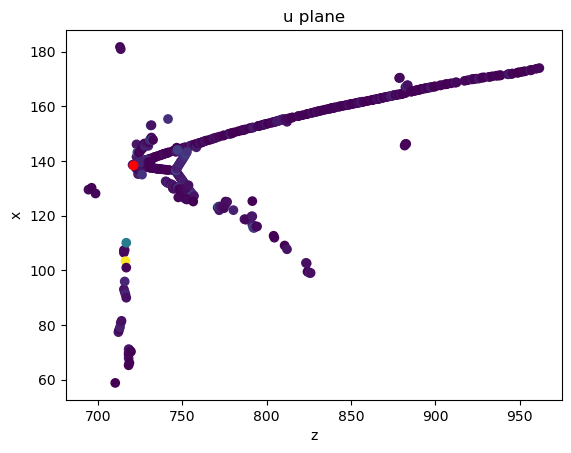

100%|██████████████████████████████████████████████████████████████████████████████| 786/786 [00:00<00:00, 4659.41it/s]


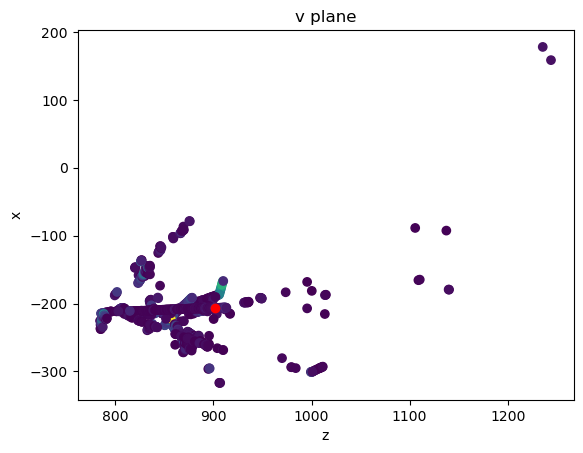

100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 4596.12it/s]


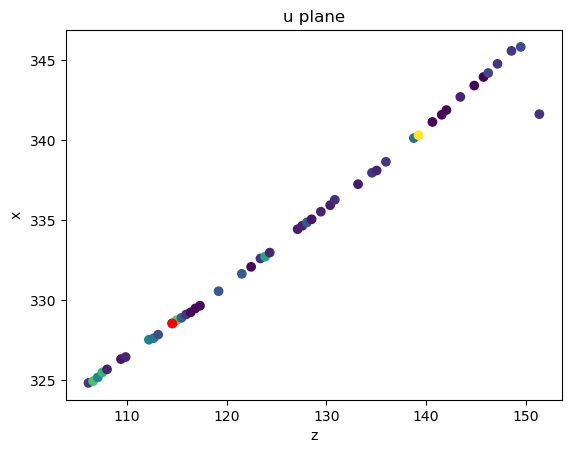

(114.512474, 328.55002, 0.09732243691352513)

In [39]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


print("Running...")


thr_std=0.2


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x






def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z
        AoI_truevtxx = u_truevtx_x
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z
        AoI_truevtxx = v_truevtx_x
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z
        AoI_truevtxx = w_truevtx_x
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0




def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x









def phi_hist(plane, event_number, thresholding=True, no_std=thr_std, leastz=False, centre_coord=(0,0), no_sectors=20, centre=0, printhist=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score




def rfunc(r):
    return 1/(r+1)



def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=20, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    
    
    weight = func(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    

    return norm_score








def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=True):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in tqdm(range(no_points)):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]

















def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std):
    
    Zvert = np.zeros((2, no_events))
    Xvert = np.zeros((2, no_events))
    
    
    for i in tqdm(range(no_events)):
        AoI_x, AoI_z, AoI_adc, Zvert[1,i], Xvert[1,i] = AoI(plane, i, thresholding, no_std)
        Zvert[0,i], Xvert[0,i] = function(plane, i)
        
    delta_z = Zvert[1] - Zvert[0]
    delta_x = Xvert[1] - Xvert[0]
    delta_r2 = delta_z**2 + delta_x**2
    
    data, bins = np.histogram(delta_r2, 30)
    
    plt.hist(data, bins)
    plt.show()
    return 0

optimise_phi("u", 11)
optimise_phi("v", 60)
optimise_phi("u", 32)

In [41]:
accuracy("u", optimise_phi, 1000)

TypeError: Cannot interpret '1000' as a data type